## Recycle June code to do APE & KE together

Previous setup didn't save anything to do with velocities but used APE and partition relation to diagnose wave energy. This might have worked for our waves but NIWs yielded more than 100% energy conversion. This time, calculate APE and KE in Fourier space, integrate superinertial components of energy and use this to diagnose total wave energy.

In [1]:
from matplotlib import rc
import numpy as np
from netCDF4 import Dataset
import xrft
import matplotlib.pyplot as plt
import os
import xarray as xr
import subprocess
import matplotlib.pyplot as plt
import shutil
os.chdir("/home/149/ab8992/bottom_near_inertial_waves/automate_experiments")

import autolib as al
from dask.distributed import Client
# client = Client(n_workers=28)
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 8,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:32971,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 8
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:35221,Total threads: 2
Dashboard: /proxy/36385/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:44649,


In [2]:
client.upload_file('autolib.py')

{'tcp://127.0.0.1:32795': {'status': 'OK'},
 'tcp://127.0.0.1:32847': {'status': 'OK'},
 'tcp://127.0.0.1:32887': {'status': 'OK'},
 'tcp://127.0.0.1:33637': {'status': 'OK'},
 'tcp://127.0.0.1:34163': {'status': 'OK'},
 'tcp://127.0.0.1:34335': {'status': 'OK'},
 'tcp://127.0.0.1:34461': {'status': 'OK'},
 'tcp://127.0.0.1:34743': {'status': 'OK'},
 'tcp://127.0.0.1:35567': {'status': 'OK'},
 'tcp://127.0.0.1:36117': {'status': 'OK'},
 'tcp://127.0.0.1:37521': {'status': 'OK'},
 'tcp://127.0.0.1:38571': {'status': 'OK'},
 'tcp://127.0.0.1:38817': {'status': 'OK'},
 'tcp://127.0.0.1:39677': {'status': 'OK'},
 'tcp://127.0.0.1:39685': {'status': 'OK'},
 'tcp://127.0.0.1:42051': {'status': 'OK'},
 'tcp://127.0.0.1:42067': {'status': 'OK'},
 'tcp://127.0.0.1:42355': {'status': 'OK'},
 'tcp://127.0.0.1:42365': {'status': 'OK'},
 'tcp://127.0.0.1:42791': {'status': 'OK'},
 'tcp://127.0.0.1:42837': {'status': 'OK'},
 'tcp://127.0.0.1:43245': {'status': 'OK'},
 'tcp://127.0.0.1:43399': {'stat

# Notebook to re-run our experiments in June. 

Want to create a master notebook that generates all of the common forcings, and the perterbation values for each experiment. Write a function that takes common & perterbation fields

| Experiment | Common | Perterbed|
| --- |---|--- |
| Topo Height | windstress | topog |
| Topo Width | Windstress | topog  |
| Forcing Width | topog | Windstress  |
| Strat | Windstress | topog|
| Duration | topog | Windstress |
| Strength | topog | Windstress |

Experiment name format:

| Type | Format |
|---|---|
| experiments | `june_perterb_hill_nlayer` |
|common topog  | `june_common_hill_nlayer`  |
|common wind | `june_common_wind_nlayer`  |


In [5]:
## Iterate over topog type and nlayers
from importlib import reload

def set_si_coords(array):
    return array.assign_coords({"time":("time",array.time.values * 60),
                             "xq":("xq",array.xq.values * 1000),
                             "xh":("xh",array.xh.values * 1000),
                             "yh":("yh",array.yh.values * 1000),
                             "yq":("yq",array.yq.values * 1000)
    })

def openexpt(pert,values,topo,layers = 2,merid = False):

    axes = {
        "KEtot":[],
        "PEtot":[],
        "windw":[],
        "xax":[]
    }
    for i in values:
        try:
            if merid == True:
                data = xr.open_dataset(f"/g/data/v45/ab8992/bottom_iwbs/august/merid_june_{pert}_{topo}_{layers}layer_{pert}-{i}")

            if merid == False:
                data = xr.open_dataset(f"/g/data/v45/ab8992/bottom_iwbs/august/june_{pert}_{topo}_{layers}layer_{pert}-{i}")
        except:
            print(f"Trouble opening {pert} {i}" )


        axes["KEtot"].append(data.KEtot.sum("zl").values) ## I'd previously multiplied by depth. This is wrong
        axes["PEtot"].append(data.PEtot.sum("zi").values)
        axes["xax"].append(i)
        axes["windw"].append(data.ww_tot.values)
        data.close()
    for i in axes:
        axes[i] = np.array(axes[i])
    return axes



class expt:
    def __init__(self,x,y,nlayers,variable,var_value,topo,common):
        self.nlayers = nlayers
        self.variable = variable
        self.var_value = var_value
        self.topo = topo
        self.common = common
        self.x = x
        self.y = y
        self.runname = f"june_{self.variable}_{self.topo}_{self.nlayers}layer_{self.variable}-{self.var_value}"
        self.exptname = f"june_{self.variable}_{self.topo}_{self.nlayers}layer"

        if not os.path.exists(f"/home/149/ab8992/bottom_near_inertial_waves/juneruns/{self.exptname}/{self.runname}"):
            os.makedirs(f"/home/149/ab8992/bottom_near_inertial_waves/juneruns/{self.exptname}/{self.runname}")

        subprocess.run(f"ln -s /g/data/v45/ab8992/mom6_channel_configs/juneruns/{self.exptname}/{self.runname} /home/149/ab8992/bottom_near_inertial_waves/juneruns/{self.exptname}/{self.runname}/inputdir",shell=True)
    
    def make_topo(self):
        if self.common == "windforcing":
            ## Make topog file
            ridge = self.topo == "ridge"
            eta = al.eta_gaussian_hill(
                nlayers=self.nlayers,
                ridge=ridge,
                nx = len(self.x),
                ny = len(self.y),
                **{self.variable : self.var_value}
                )

            al.save_topo(self.x,
                 self.y,
                 None,
                 None,
                 eta,
                 f"/juneruns/{self.exptname}/{self.runname}",
                 savewind = False,
                 **{self.variable : self.var_value}
                 )
        elif self.common == "topog":
            ## Make and save wind stress
            STRESS_X = al.windstress_gaussian(nx = len(self.x),
                                           ny = len(self.y),
                                           reverse = True,
                                           **{self.variable : self.var_value})
            al.save_topo(self.x,
                self.y,
                STRESS_X,
                STRESS_X * 0,
                np.zeros((1,len(self.y),len(self.x))),
                f"/juneruns/{self.exptname}/{self.runname}",
                savedensities = False
                )
        return
    
    def setup(self,overrides = None,walltime = None,default_dir = None,run_duration = 10,forcing_path=None):
        print("SETUP: " + self.runname)

        # june_common_ridge_{nlayers}layers
        if forcing_path == None:
            forcing_path = f"juneruns/{self.exptname}/{self.runname}" 

        if self.common == "topog":
            common_forcing_path = f"june_common_{self.topo}_{self.nlayers}layers"
        elif self.common == "windforcing":
            common_forcing_path = f"june_common_wind"
        al.setup_mom6(f"juneruns/{self.exptname}/{self.runname}",
                    forcing_path,
                    walltime = walltime,
                    overrides = overrides + [f"NK={self.nlayers}"],
                    common_forcing = f"juneruns/common/{common_forcing_path}",
                    default_dir=default_dir,
                    run_duration = run_duration
                    )   

    def run(self):
        print("RUNNING: " + self.runname)
        al.run_mom6(f"{self.exptname}/{self.runname}")   
        return
    def set_noforcing(self):
        subprocess.run(
            "/home/149/ab8992/bottom_near_inertial_waves/automated/forcing_off.sh",
            cwd = f"/home/149/ab8992/bottom_near_inertial_waves/juneruns/{self.exptname}/{self.runname}")        
        return
    def fastrun(self):
        subprocess.run(
            "payu run -f",shell= True,cwd = f"/home/149/ab8992/bottom_near_inertial_waves/juneruns/{self.exptname}/{self.runname}"
        )
        return


    def process_output(self,merid = False,basepath = "/g/data/v45/ab8992/bottom_iwbs/",foldername = "august"):
        

        xh = np.arange(-1999,2000,2.)
        yh = np.arange(-1999,-1000,2)


        if merid == False:
            outpath = basepath +  "/" + foldername + "/" + self.runname ## Modification to allow function to work as class

            dim = "xh"
            otherdim = "yh"
            sliceint = 250
            eslice = xr.open_mfdataset(
                f"/home/149/ab8992/bottom_near_inertial_waves/juneruns/{self.exptname}/{self.runname}/archive/output00*/e_10min.nc",chunks = {"zi":1},decode_times = False).isel({otherdim : sliceint,"time" : slice(0,4152//2)}).isel(zi = slice(1,5))

            #! Warning, this is not interpolating correctly. Hardcoded for zonal slice only, selects middle yq value for v
            vslice = xr.open_mfdataset(
                f"/home/149/ab8992/bottom_near_inertial_waves/juneruns/{self.exptname}/{self.runname}/archive/output00*/v_10min.nc",chunks = {"zi":1},decode_times = False).isel({"yq" : sliceint,"time" : slice(0,4152//2)})
            uslice = xr.open_mfdataset(
                f"/home/149/ab8992/bottom_near_inertial_waves/juneruns/{self.exptname}/{self.runname}/archive/output00*/u_10min.nc",chunks = {"zi":1},decode_times = False).isel({otherdim : sliceint,"time" : slice(0,4152//2)}).interp(xq = xh).rename({"xq":"xh"})
            tauslice = xr.open_dataset(
                f"/home/149/ab8992/bottom_near_inertial_waves/juneruns/{self.exptname}/{self.runname}/archive/output000/taux_10min.nc",decode_times = False).isel({otherdim : sliceint}).interp(xq = xh).rename({"xq":"xh"})

        if merid == True:
            outpath = basepath +  "/" + foldername + "/merid_" + self.runname ## Modification to allow function to work as class

            dim = "yh"
            otherdim = "xh"
            sliceint = 2
            eslice = xr.open_mfdataset(
                f"/home/149/ab8992/bottom_near_inertial_waves/juneruns/{self.exptname}/{self.runname}/archive/output00*/e_10min.nc",chunks = {"zi":1,"time":-1},decode_times = False).isel({otherdim : sliceint,"time" : slice(0,4152//2)}).isel(zi = slice(1,5))

            #! Warning, this is not interpolating correctly. Hardcoded for zonal slice only, selects middle yq value for v
            vslice = xr.open_mfdataset(
                f"/home/149/ab8992/bottom_near_inertial_waves/juneruns/{self.exptname}/{self.runname}/archive/output00*/v_10min.nc",chunks = {"zl":1},decode_times = False).isel({"xh" : sliceint,"time" : slice(0,4152//2)}).interp(yq=yh).rename({"yq":"yh"})
            uslice = xr.open_mfdataset(
                f"/home/149/ab8992/bottom_near_inertial_waves/juneruns/{self.exptname}/{self.runname}/archive/output00*/u_10min.nc",chunks = {"zl":1},decode_times = False).isel({"xq" : sliceint,"time" : slice(0,4152//2)})
            tauslice = xr.open_mfdataset(
                f"/home/149/ab8992/bottom_near_inertial_waves/juneruns/{self.exptname}/{self.runname}/archive/output000/taux_10min.nc",decode_times = False).isel({"xq" : sliceint})

        forcing_time = tauslice.time.shape[0]





        e = eslice.e.assign_coords({"time":("time",eslice.time.values * 60),
                                dim:(dim,eslice[dim].values * 1000)
            })
        u = uslice.u.assign_coords({"time":("time",uslice.time.values * 60),
                                dim:(dim,uslice[dim].values * 1000)
            })

        v = vslice.v.assign_coords({"time":("time",vslice.time.values * 60),
                                dim:(dim,vslice[dim].values * 1000)
            })

        tau = tauslice.taux.assign_coords({"time":("time",tauslice.time.values * 60),
                                dim:(dim,tauslice[dim].values * 1000)
            })


        eanom = (e - e.mean(dim))
        eslice.close()
        uslice.close()
        vslice.close()
        tauslice.close()
        print("files closed")
        ## Flip and double time axis to remove ringing from FFT
        eanom_flipped = xr.DataArray(
            data = eanom[::-1,:,:],
            coords = [600 - eanom.time[::-1],eanom.zi,eanom[dim]],
            dims = ["time","zi",dim]
        )
        u_flipped = xr.DataArray(
            data = u[::-1,:,:],
            coords = [600 - u.time[::-1],u.zl,u[dim]],
            dims = ["time","zl",dim]
        )
        v_flipped = xr.DataArray(
            data = v[::-1,:,:],
            coords = [600 - v.time[::-1],v.zl,v[dim]],
            dims = ["time","zl",dim]
        )

        e_doubled = xr.concat([eanom_flipped,eanom],dim = "time").chunk({"time":-1})
        u_doubled = xr.concat([u_flipped,u],dim = "time").chunk({"time":-1})
        v_doubled = xr.concat([v_flipped,v],dim = "time").chunk({"time":-1})

        del u_flipped
        del v_flipped
        del eanom_flipped

        strat = 1
        if "strat" in self.runname:
            strat = float(self.runname.split("-")[-1])

        drho = (e.zi[1] - e.zi[0]).values

        gprime = strat * 9.8 * drho / 1027
        f = 0.0001 / (2 * np.pi)

        PE = 1027 * gprime * xrft.power_spectrum(e_doubled,dim=["time",dim],true_phase = True,true_amplitude = True)

        # Scale KE by layer thickness, density and divide by 2 from 0.5v^2
        KE = (4000 / 5) * 1027 * 0.5 * (
            xrft.power_spectrum(u_doubled,dim=["time",dim],true_phase = True,true_amplitude = True)
            + xrft.power_spectrum(v_doubled,dim=["time",dim],true_phase = True,true_amplitude = True))

        ## ADD THIS LINE TO REMOVE SUBINERTIAL SIGNALS
        # PE_filtered = PE.where(np.abs(PE.freq_time) > f,0)
        # KE_filtered = KE.where(np.abs(KE.freq_time) > f,0).where(KE.freq_xh != 0,0)
        PEtot =  PE.where(np.abs(PE.freq_time) > f,0).sum("freq_time").sum(f"freq_{dim}") / (e_doubled.time.shape[0] * 600)
        KEtot =  KE.where(np.abs(KE.freq_time) > f,0).where(KE[f"freq_{dim}"] != 0,0).sum("freq_time").sum(f"freq_{dim}") / (e_doubled.time.shape[0] * 600)

        ww = (u.isel(zl = 0,time = slice(0,forcing_time)) * tau)
        ww_tot = ww.integrate("time").integrate(dim)

        ## Commentted out include spectrum in saved files
        out = xr.Dataset(
            {"PE":PE.sel({"freq_time" : slice(0,None),f"freq_{dim}" : slice(0,None)}),
            "PEtot":PEtot,
            "KEtot":KEtot,
            "KE":KE.sel({"freq_time" : slice(0,None),f"freq_{dim}" : slice(0,None)}),
            "ww_tot":ww_tot}
        )

        out.to_netcdf(outpath)




## Perterbation values
## strat variables 
strats = [0.25,0.2,0.5,0.75,1,1.5,2,3,4,0.001,0.01,6]

## Height
heights = [10,20,50,80,120,150,225,275,350,450,600,750]

## Duration
durations = [0.5,1,2,3,4,5,6,8.7,10] ## Note! Will need to modify the amount of time that model runs for with forcing in this case

## Strength
strengths = [0.1,0.2,0.5,0.75,1,1.25,1.5,2,3,4,10]

## Topog Width
widths = [4,8,12.5,16,25,35,50,100,200] 

## Forcing Width
forcing_widths = [25,50,75,100,150,175,200,300,500,800,1000]

### COMMON ACROSS ALL EXPERIMENTS. 
##########################################################
nlayers = 2             # number of layers
Lx = 4000                # domain zonal extent [km]
Ly = 1000                # domain meridional extent [km]
H  = 4000                # total fluid's depth in [m]
gridspacing = 2          # in [km]
flat = False
reverse = True
x = np.arange(0, Lx, gridspacing)
y = np.arange(-Ly/2, Ly/2, gridspacing)
ninterf = nlayers + 1    # number of interfaces
interfaces = np.arange(0,  ninterf)
nx = int(round(Lx/gridspacing))
ny = int(round(Ly/gridspacing))
overrides = ["ADIABATIC = True",
             "RHO_0 = 1027.0",
             f"NJGLOBAL={ny}",
             f"NIGLOBAL={nx}",
             f"LENLON = {Lx}.0",
             f"WESTLON = -{Lx//2}.0",
             f"LENLAT = {Ly}.0",
             f"WESTLAT = -{Ly//2}.0"]
default_dir = "default_rundir"


## Default values when unperturbed
default_height = 500 # m
default_forcing_latwidth = 300 # km
default_duration = 5 # hours
default_layerdensities = np.linspace(1027,1029,nlayers) ## This is the default stratification
default_strength = 1
default_ridge_width = 12.5 # km

## Perterbation values
## strat variables 
strats = [0.001,0.01,0.2,0.25,0.5,0.75,1,1.5,2]

## Height
heights = [10,20,50,80,120,150,225,275,350,450,600,750]

## Duration
durations = [0.5,1,2,3,4,5,6,7,8,8.7,10,12,14,15,16,20] 
durations = [0.5,1,2,3,4,5,6,7,8,8.7,10,12] 

## Strength
strengths = [0.1,0.2,0.5,0.75,1,1.25,1.5,2,3,4,10]

## Topog Width
widths = [4,8,12.5,16,25,35,50,100,200] 

## Forcing Width
forcing_widths = [25,50,75,100,150,175,200,300,500,800,1000]


expts = []
k = [5]
topos = ["ridge"]
# k = [2]
# topos = ["hill"]

for nlayers in k:
    for topo in topos:
        ## HEIGHTS
        for height in heights:
            run = expt(x,y,nlayers,"height",height,topo,"windforcing")
            expts.append(run)

        ## STRATS
        for strat in strats:
            run = expt(x,y,nlayers,"strat",strat,topo,"windforcing")
            expts.append(run)

        ## TOPO WIDTHS
        for width in widths:
            run = expt(x,y,nlayers,"width",width,topo,"windforcing")
            expts.append(run)


        ## WIND FORCING EXPERIMENTS
        # Here we recycle the wind forcing since it doesn't change with topo
        ## FORCING WIDTHS
        for forcing_width in forcing_widths:
            run = expt(x,y,nlayers,"forcing_latwidth",forcing_width,topo,"topog")
            expts.append(run)


        ## STRENGTHS
        for strength in strengths:
            run = expt(x,y,nlayers,"strength",strength,topo,"topog")
            expts.append(run)

            ## DURATIONS
        for duration in durations:
            run = expt(x,y,nlayers,"duration",duration,topo,"topog")
            expts.append(run)

ln: failed to create symbolic link '/home/149/ab8992/bottom_near_inertial_waves/juneruns/june_height_ridge_5layer/june_height_ridge_5layer_height-10/inputdir/june_height_ridge_5layer_height-10': File exists
ln: failed to create symbolic link '/home/149/ab8992/bottom_near_inertial_waves/juneruns/june_height_ridge_5layer/june_height_ridge_5layer_height-20/inputdir/june_height_ridge_5layer_height-20': File exists
ln: failed to create symbolic link '/home/149/ab8992/bottom_near_inertial_waves/juneruns/june_height_ridge_5layer/june_height_ridge_5layer_height-50/inputdir/june_height_ridge_5layer_height-50': File exists
ln: failed to create symbolic link '/home/149/ab8992/bottom_near_inertial_waves/juneruns/june_height_ridge_5layer/june_height_ridge_5layer_height-80/inputdir/june_height_ridge_5layer_height-80': File exists
ln: failed to create symbolic link '/home/149/ab8992/bottom_near_inertial_waves/juneruns/june_height_ridge_5layer/june_height_ridge_5layer_height-120/inputdir/june_height_r

## Plot the experiments

In [4]:
from IPython.display import clear_output


tot = len(expts)
curr = 41
for i in expts[41:]:
    clear_output()
    print(f"{curr}/{tot} {100 * curr/tot}% complete. \t\t Processing {i.runname}. ")
    i.process_output(foldername = "august" , merid = True)
    i.process_output(foldername = "august" , merid = False)

    curr += 1
# up to 45 i.e strength 1

41/68 60.294117647058826% complete. 		 Processing june_strength_ridge_5layer_strength-0.1. 
files closed
files closed


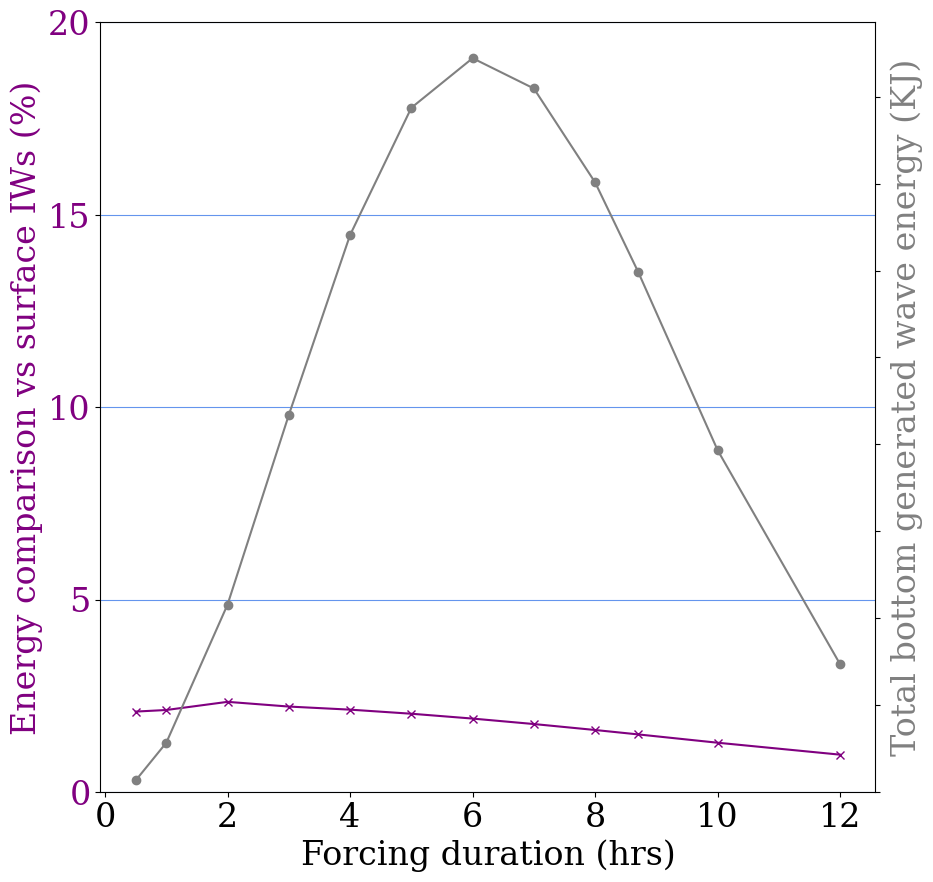

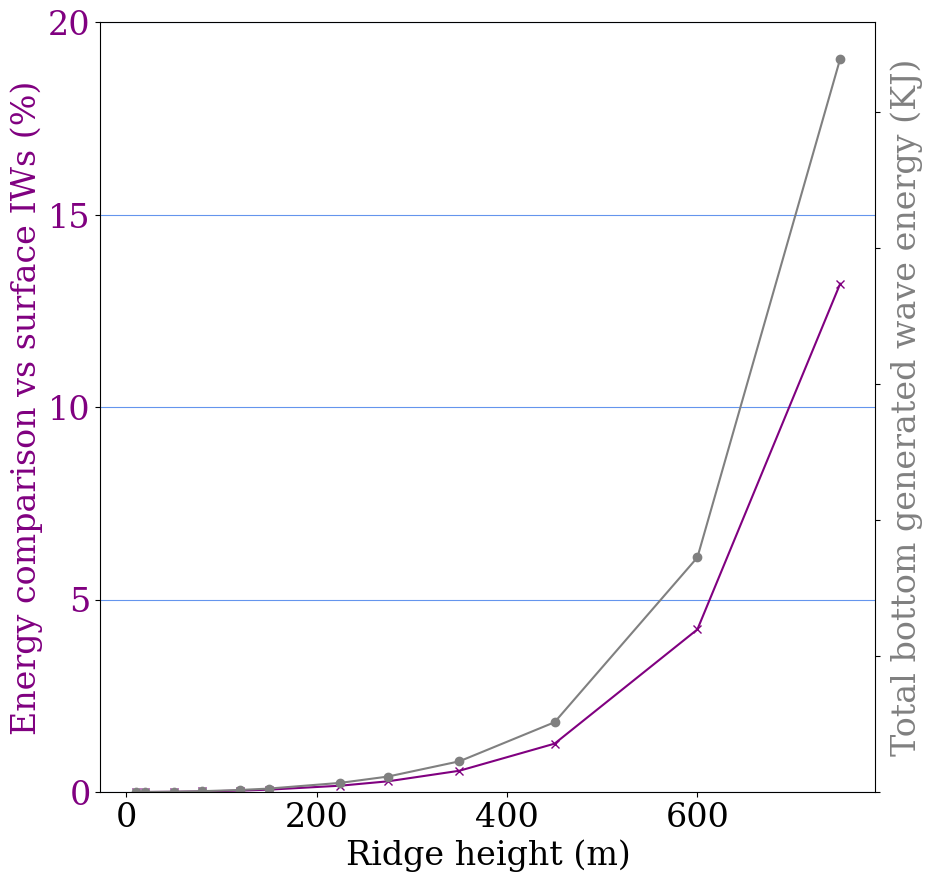

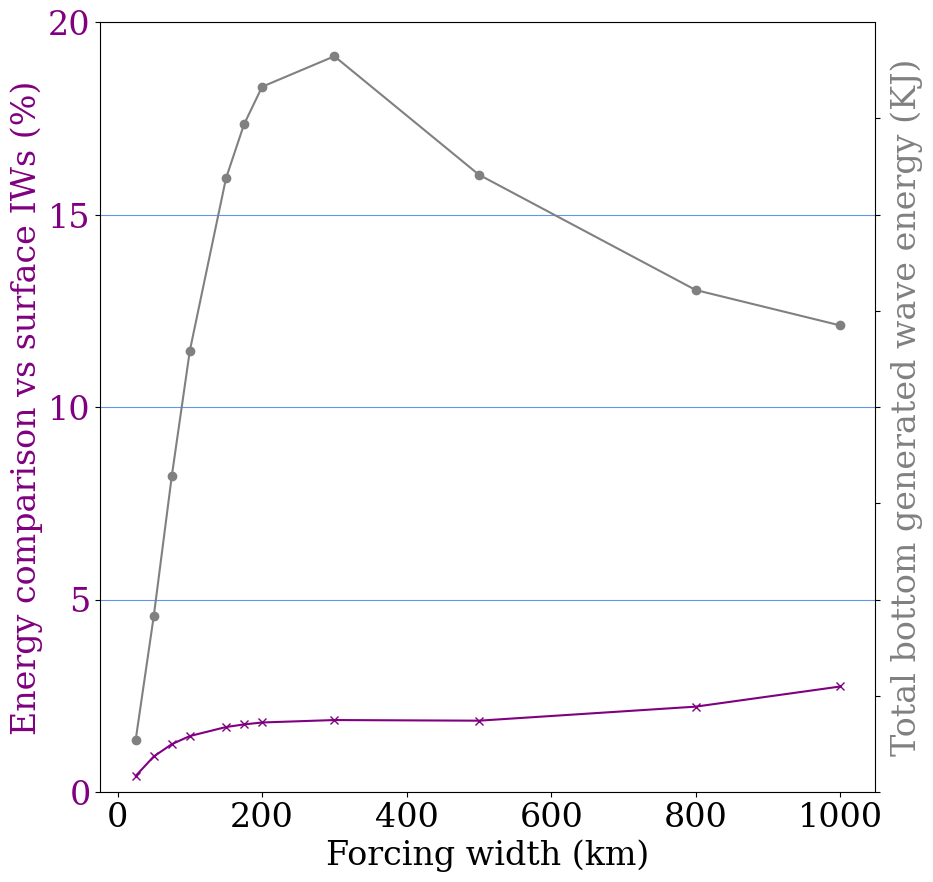

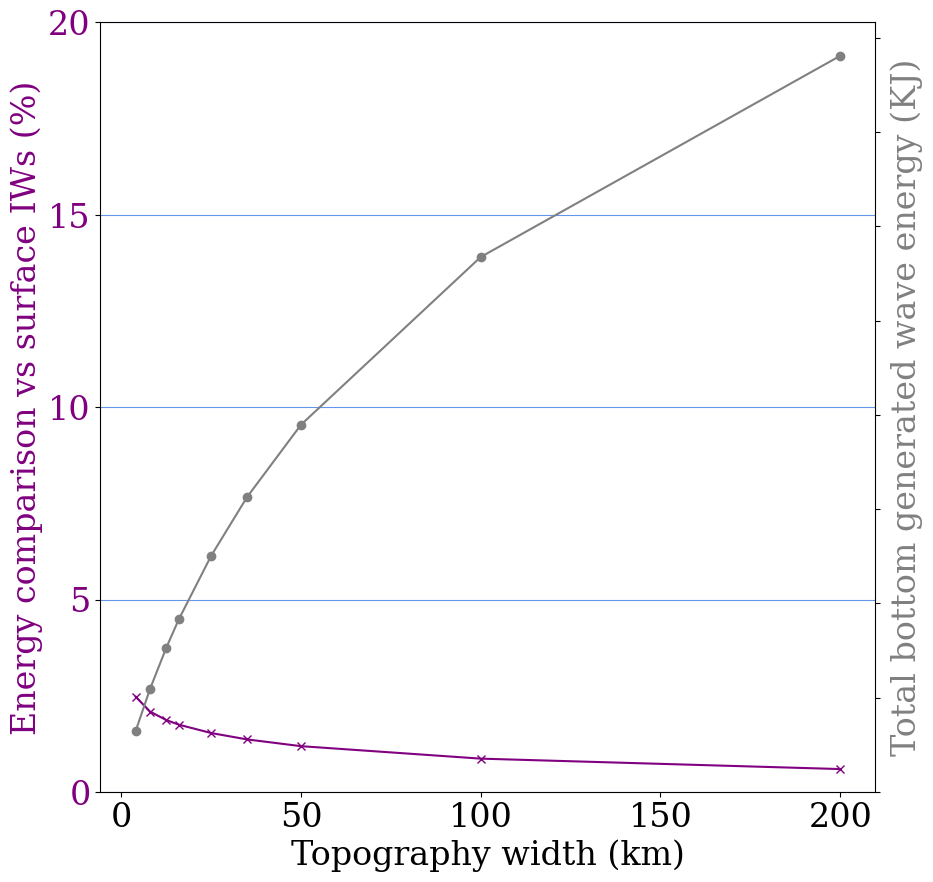

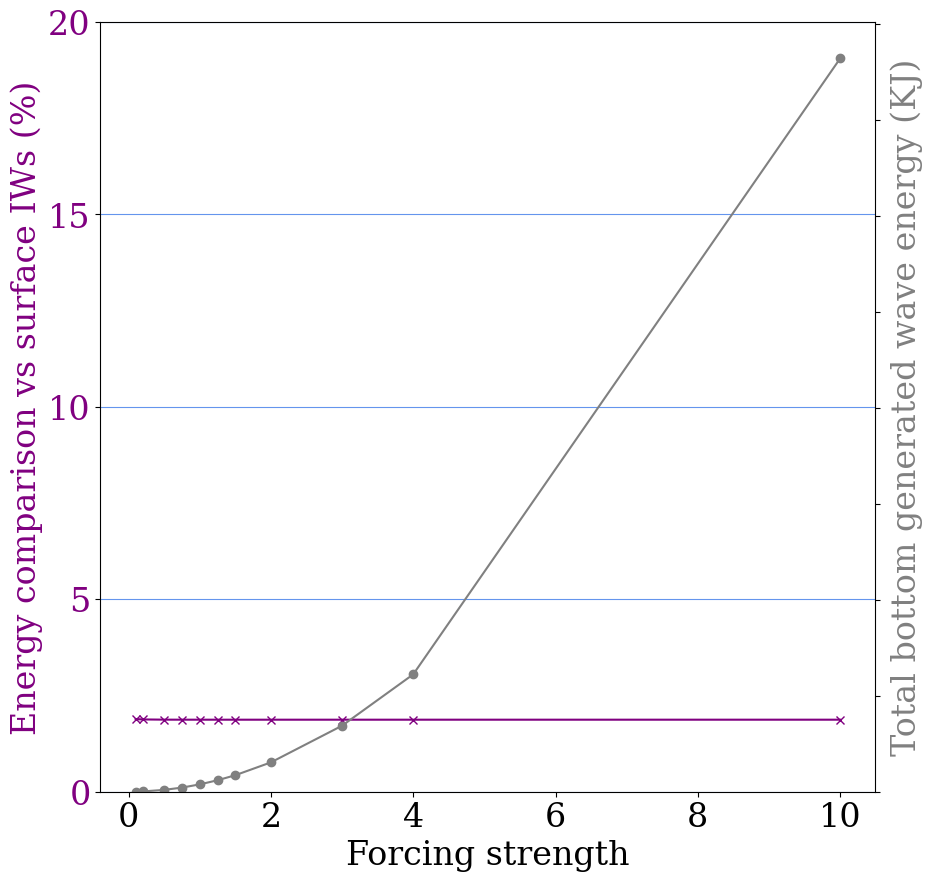

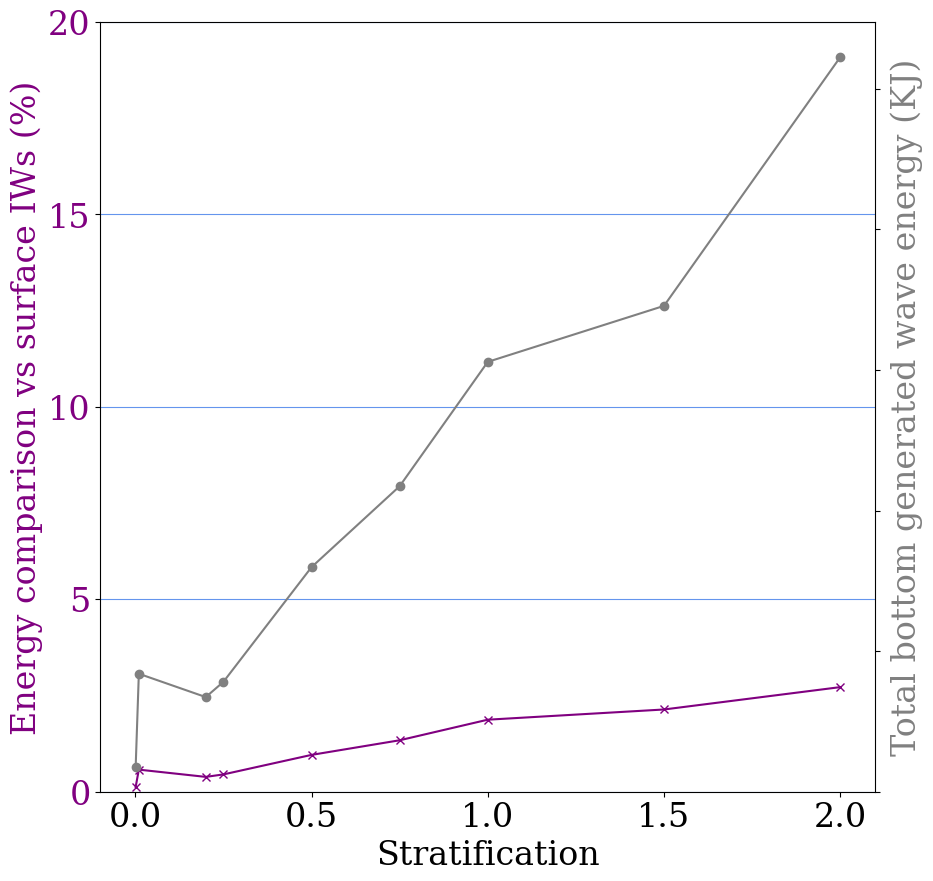

In [8]:
from mpl_toolkits.axes_grid1 import host_subplot
from mpl_toolkits import axisartist
def openexpt(pert,values,topo,layers = 2,merid = False):

    axes = {
        "KEtot":[],
        "PEtot":[],
        "windw":[],
        "xax":[]
    }
    for i in values:
        try:
            if merid == True:
                data = xr.open_dataset(f"/g/data/v45/ab8992/bottom_iwbs/august/merid_june_{pert}_{topo}_{layers}layer_{pert}-{i}")

            if merid == False:
                data = xr.open_dataset(f"/g/data/v45/ab8992/bottom_iwbs/august/june_{pert}_{topo}_{layers}layer_{pert}-{i}")
        except:
            print(f"Trouble opening {pert} {i}" )


        axes["KEtot"].append(data.KEtot.sum("zl")) ## I'd previously multiplied by depth. This is wrong
        axes["PEtot"].append(data.PEtot.sum("zi"))
        axes["xax"].append(i)
        axes["windw"].append(data.ww_tot.values)
        data.close()
    for i in axes:
        axes[i] = np.array(axes[i])
    return axes


def plotexpt(name,pert,xlabel,xlim = None,ylim = None,scale_windwork = 50 / 2000,merid = False):


    fig = plt.figure(figsize = (10,10))

    ax2 = host_subplot(111)

    fig.add_axes(ax2)

    toplotr = openexpt(name,pert,"ridge",layers = 5,merid=False)
    toplot_merid = openexpt(name,pert,"ridge",layers = 5,merid=True)
    # toploth = openexpt(name,pert,"hill",layers = 5)
    ax = ax2.twinx()

    ax.plot(toplotr["xax"],(toplotr["KEtot"] + toplotr["PEtot"]) /1e3,marker = "o",label = "Total energy",color = "grey")

    # plt.scatter(toploth["xax"],toploth["Etot"]/1e3,marker = "x",label = "E Hill")
    # plt.scatter(toploth["xax"],toploth["PEtot"]/1e3,marker = "x",label = "PE Hill")

    ax.set_title("Time averaged wave energy in domain",color = "grey")
    ax.set_ylabel("Total bottom generated wave energy (KJ)",color = "grey")
    ax2.set_xlabel(xlabel)
    if name == "width":
        scale_windwork = 4 * toplotr["xax"] / 2000

    conversion_zon = (toplotr["PEtot"] + toplotr["KEtot"]) / (scale_windwork * toplotr["windw"])
    conversion_merid = (toplot_merid["PEtot"] + toplot_merid["KEtot"]) / (toplot_merid["windw"])
    
    ax2.plot(toplotr["xax"], 100 *  conversion_zon / conversion_merid,label = "Energy Convsrsion",color = color,marker = "x")
    # print(toplotr["windw"] * scale_windwork / 1e3)
    ax.set_ylim(0,None)
    ax2.set_ylabel("Energy comparison vs surface IWs (%)", color = color)
    # ax.legend()
    ax2.set_ylim(0,20)
    ax2.set_yticks(np.arange(0,21,5))
    ax2.set_yticklabels(np.arange(0,21,5),color = color)
    ax.set_yticklabels([],color = color)
    ax2.grid(True,axis = "y",color = "cornflowerblue")
    ax.set_title("")


# plotexpt("height",heights,"m",ylim = (0,1e6))

# plotexpt("forcing_latwidth",forcing_widths,"m",ylim = (0,1e6))
plotexpt("duration",durations,"Forcing duration (hrs)")
plotexpt("height",heights,"Ridge height (m)")
plotexpt("forcing_latwidth",forcing_widths,"Forcing width (km)")
plotexpt("width",widths,"Topography width (km)")
plotexpt("strength",strengths,"Forcing strength")
plotexpt("strat",strats,"Stratification")

In [ ]:
from mpl_toolkits.axes_grid1 import host_subplot
from matplotlib.lines import Line2D

from mpl_toolkits import axisartist


def plotexpt(name,pert,xlabel,xlim = None,ylim = None,scale_windwork = 50 / 2000,merid = False):

    color1 = "black"
    color2 = "cornflowerblue"
    marker1 = "o"
    marker2 = "x"

    zonaldata = openexpt(name,pert,"ridge",layers = 5,merid=False)
    meriddata = openexpt(name,pert,"ridge",layers = 5,merid=True)
    # toploth = openexpt(name,pert,"hill",layers = 5)

    zonal_ratio = (zonaldata["KEtot"] + zonaldata["PEtot"] ) / (scale_windwork * zonaldata["windw"])
    merid_ratio = (meriddata["KEtot"] + meriddata["PEtot"] ) / (meriddata["windw"])
    print(name)
    print(np.round(100 * zonal_ratio))
    print(np.round(100 * merid_ratio))
    print("")
    fig,ax = plt.subplots(figsize = (10,10))

    ax.plot(zonaldata["xax"],(zonaldata["KEtot"] + zonaldata["PEtot"] )/1e3,marker = marker1,label = "Zonal NIW energy",color = color1)
    ax.plot(meriddata["xax"],(meriddata["KEtot"] + meriddata["PEtot"] )/1e3,marker = marker1,linestyle = ":",label = "Meridional NIW energy",color = color1)

    # plt.scatter(toploth["xax"],toploth["Etot"]/1e3,marker = "x",label = "E Hill")
    # plt.scatter(toploth["xax"],toploth["PEtot"]/1e3,marker = "x",label = "PE Hill")

    ax.set_title("Time averaged wave energy in domain")
    ax.set_ylabel("Total energy (KJ)",color = color1)
    ax.set_xlabel(xlabel)
    ax2 = ax.twinx()
    # print(zonaldata["KEtot"])
    if name == "width":
        scale_windwork = 4 * zonaldata["xax"] / 2000
    # ax2.plot(toplotr["xax"], scale_windwork * toplotr["windw"]/1e3,label = "Energy Convsrsion",color = "black",marker = "x")
    ax2.plot(zonaldata["xax"], 100 *  zonal_ratio,label = "Zonal Energy Convsrsion",linestyle = "solid",color = color2,marker = marker2)
    ax2.plot(meriddata["xax"], 100 *  merid_ratio ,label = "Merid Energy Conversion",linestyle = ":",color = color2,marker = marker2)

    ax2.set_yscale("log")
    ax2.set_yticks([1,5,10,25,50,75,100])
    ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    # ax2.set_yticks([1,5,10,25,50,75,100],minor = True)
    ax.set_yscale("log")
    # put numbers on y axes corresponding to 1,5,10,25,50,75,100
    # ax2.set_yticklabels([1,5,10,25,50,75,100])
    # Put horizontal lines at tick points of plot


    ax2.set_ylabel("Conversion rate (% of Wind Work)",color = color2)
    # ax.legend()
    # ax2.legend()

    legend_elements = [
        Line2D([0], [0], color="black", lw=2, label='Zonal Waves'),
        Line2D([0], [0], color="black", linestyle=":",lw=2, label='Meridional Waves'),
        # Line2D([0], [0], color=color1, marker = marker1, lw=2, label='Total wave energy'),
        # Line2D([0], [0], color=color2, marker = marker2, lw=2, label='Conversion rate')

    ]
    ticks = [0.5,1,5,10,25,50]

    ax2.set_yticks([],minor = True)
    ax2.set_yticks(ticks,minor = False)
    ax2.set_yticklabels(ticks,color = color2)
    ax.tick_params(axis='y', colors=color1)
    ax.legend(handles=legend_elements)
    ax2.grid(True,axis = "y",color = color2)
    ax2.grid(True,axis = "y",color = color2)
    ax.set_ylim(1e-1,1e5)
    # ax2.set_ylim(0.05,50)

plotexpt("duration",durations,"Forcing duration (hrs)")
plotexpt("height",heights,"Ridge height (m)")
plotexpt("forcing_latwidth",forcing_widths,"Forcing width")
plotexpt("width",widths,"Topography width (km)")
plotexpt("strength",strengths,"Forcing strength")
plotexpt("strat",strats,"Stratification")

## Plot all experiments together in one figure 

In [6]:
data = {
    "strength" : {
        "xlabel" : r"Forcing strength (N/m$^2$) ",
        "zonaldata" : openexpt("strength",strengths,"ridge",layers = 5,merid=False),
        "meriddata" : openexpt("strength",strengths,"ridge",layers = 5,merid=True),
    },
    "duration" : {
        "xlabel" : "Forcing duration (hours)",
        "zonaldata" : openexpt("duration",durations,"ridge",layers = 5,merid=False),
        "meriddata" : openexpt("duration",durations,"ridge",layers = 5,merid=True),
    },
    "forcing_latwidth" : {
        "xlabel" : "Forcing width (km)",
        "zonaldata" : openexpt("forcing_latwidth",forcing_widths,"ridge",layers = 5,merid=False),
        "meriddata" : openexpt("forcing_latwidth",forcing_widths,"ridge",layers = 5,merid=True),
    },
    "height" : {
        "xlabel" : "Ridge height (m)",
        "zonaldata" : openexpt("height",heights,"ridge",layers = 5,merid=False),
        "meriddata" : openexpt("height",heights,"ridge",layers = 5,merid=True),
    },
    "width" : {
        "xlabel" : "Topography width (km) ",
        "zonaldata" : openexpt("width",widths,"ridge",layers = 5,merid=False),
        "meriddata" : openexpt("width",widths,"ridge",layers = 5,merid=True),
    },
    "strat" : {
        "xlabel" : r"Buoyancy frequency (Factor of $f$) ",
        "zonaldata" : openexpt("strat",strats,"ridge",layers = 5,merid=False),
        "meriddata" : openexpt("strat",strats,"ridge",layers = 5,merid=True),
    }

}

data["strength"]["zonaldata"]["xax"] *= 0.5
data["strength"]["meriddata"]["xax"] *= 0.5
data["strat"]["meriddata"]["xax"] *= 20
data["strat"]["zonaldata"]["xax"] *= 20
data["duration"]["zonaldata"]["xax"] *= 2
data["duration"]["meriddata"]["xax"] *= 2
for i in ["zonaldata","meriddata"]:
    for j in ["KEtot","PEtot","xax","windw"]:
        data["strat"][i][j] = data["strat"][i][j][2:]

0 strength
1 duration
2 forcing_latwidth
3 height
4 width
5 strat


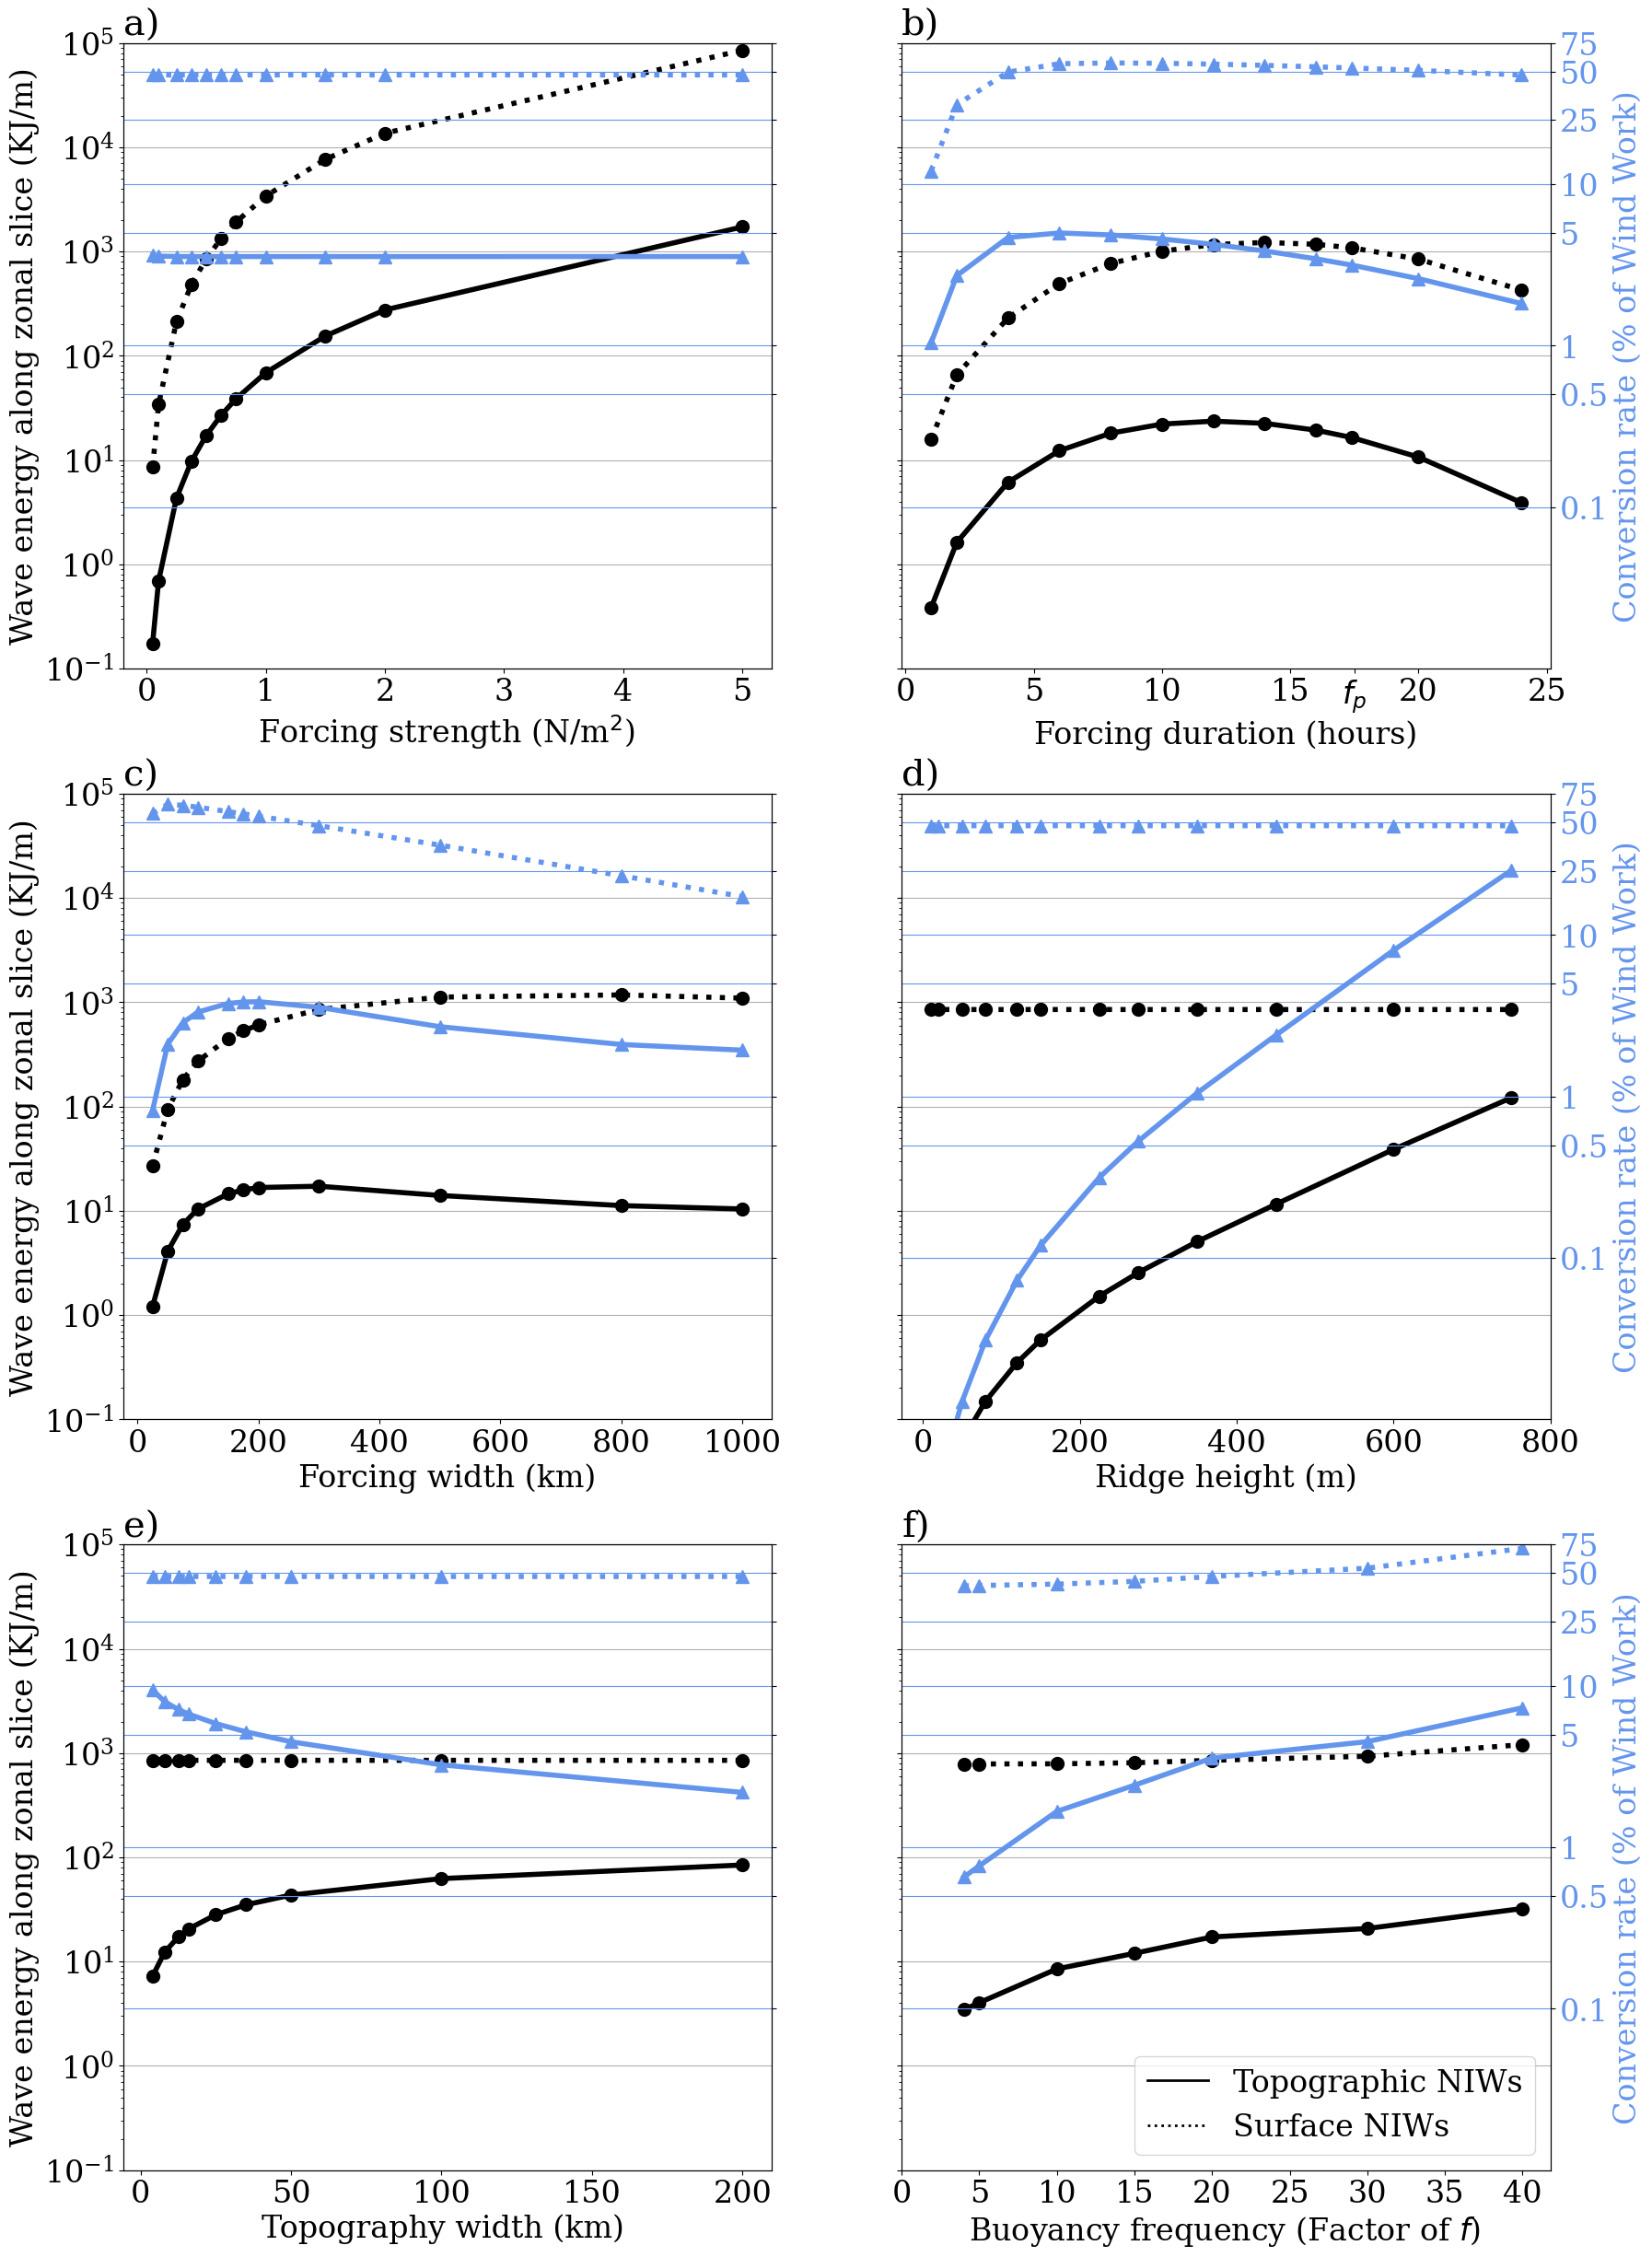

In [12]:
import matplotlib
from matplotlib.lines import Line2D
import matplotlib
font = {'family' : 'serif',
        'weight':'normal',
        'size'   : 24}
lw = 4
msize = 10
color1 = "black"
color2 = "cornflowerblue"
marker1 = "o"
marker2 = "^"
scale_windwork = 25 / 4000

matplotlib.rc('font', **font)
color = "purple"
fig,axes = plt.subplots(3,2,figsize = (20,30),sharey = True)

for i,name in enumerate(data):
    print(i,name)
    ax = axes[i // 2,i % 2]

    if name == "width":
        scale_windwork = data[name]["zonaldata"]["xax"] / 4000
    else:
        scale_windwork = 25 / 4000

    zonal_ratio = (data[name]["zonaldata"]["KEtot"] + data[name]["zonaldata"]["PEtot"] * 2 ) / (scale_windwork * data[name]["zonaldata"]["windw"])
    merid_ratio = (data[name]["meriddata"]["KEtot"] + data[name]["meriddata"]["PEtot"] * 2) / (data[name]["meriddata"]["windw"])

    ax.plot(data[name]["zonaldata"]["xax"],(data[name]["zonaldata"]["KEtot"] + data[name]["zonaldata"]["PEtot"]*2 )/1e3, markersize = msize,lw = lw,marker = marker1,label = "Zonal NIW energy",color = color1)
    ax.plot(data[name]["meriddata"]["xax"],(data[name]["meriddata"]["KEtot"] + data[name]["meriddata"]["PEtot"]*2 )/1e3,markersize = msize,lw = lw,marker = marker1,linestyle = ":",label = "Meridional NIW energy",color = color1)

    # ax.set_title("Time averaged wave energy in domain")
    ax.set_ylabel("Wave energy along zonal slice (KJ/m)",color = color1)
    ax.set_xlabel(data[name]["xlabel"])
    ax2 = ax.twinx()

    ax2.plot(data[name]["zonaldata"]["xax"], 100 *  zonal_ratio,label = "Zonal Energy Convsrsion",markersize = msize,lw = lw,linestyle = "solid",color = color2,marker = marker2)
    ax2.plot(data[name]["meriddata"]["xax"], 100 *  merid_ratio ,label = "Merid Energy Conversion",markersize = msize,lw = lw,linestyle = ":",color = color2,marker = marker2)

    ax2.set_yscale("log")
    # ax2.set_scale("log")
    ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.set_yscale("log")
    # ax.set_scale("log")
    ax2.set_ylabel("Conversion rate (% of Wind Work)",color = color2)


    if name == "strat":
        ax.set_xticks([0,5,10,15,20,25,30,35,40]) 
    if name == "height":
        ax.set_xticks([0,200,400,600,800]) 
    if name == "duration":
        ax.set_xticks([0,5,10,15,17.5,20,25]) 
        ax.set_xticklabels([0,5,10,15,r"$f_p$",20,25]) 
    legend_elements = [
        Line2D([0], [0], color="black", lw=2, label='Topographic NIWs'),
        Line2D([0], [0], color="black", linestyle=":",lw=2, label='Surface NIWs'),
    ]

    ticks = [0.1,0.5,1,5,10,25,50,75]


    ax2.set_yticks([],minor = True)
    ax2.set_yticks(ticks,minor = False)
    ax2.set_yticklabels(ticks,color = color2)
    # ax.set_yticklabels([1e-1,1,10,1e2,1e3,1e4,1e5])
    ax.grid(True,axis = "y")
    ax2.grid(True,axis = "y",color = color2)
    ax.set_ylim(1e-1,1e5)
    ax2.set_ylim(1e-2,75)
    ax.set_title(["a)","b)","c)","d)","e)","f)"][i],loc = "left")
    if i == 5:
        ax.legend(handles=legend_elements,loc = "lower right")
    if i %2 == 0:
        ax2.set_ylabel("")
        ax2.set_yticklabels([])
    else:
        ax.set_ylabel("")
        # ax.set_yticklabels([])


R-squared error for strength zonal fit: 0.999999999841974
R-squared error for duration zonal fit: 0.9528150353795981
R-squared error for forcing_latwidth zonal fit: 0.6199104612011815
R-squared error for height zonal fit: 0.9493787170378616
R-squared error for width zonal fit: 0.9932540372319042
R-squared error for strat zonal fit: 0.9765971443694575


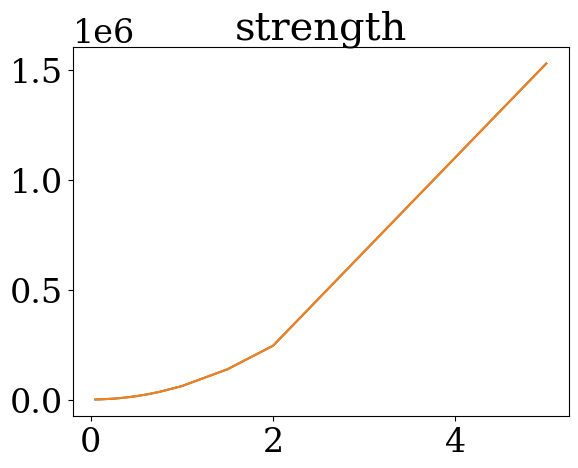

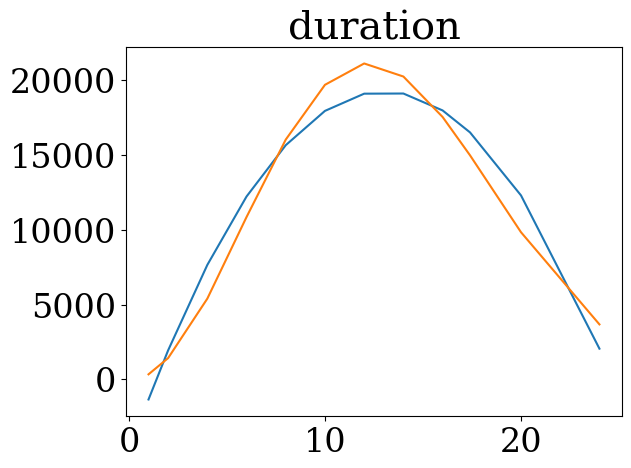

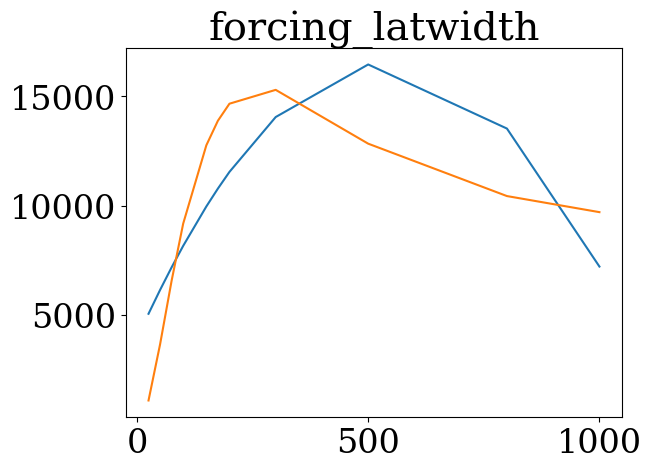

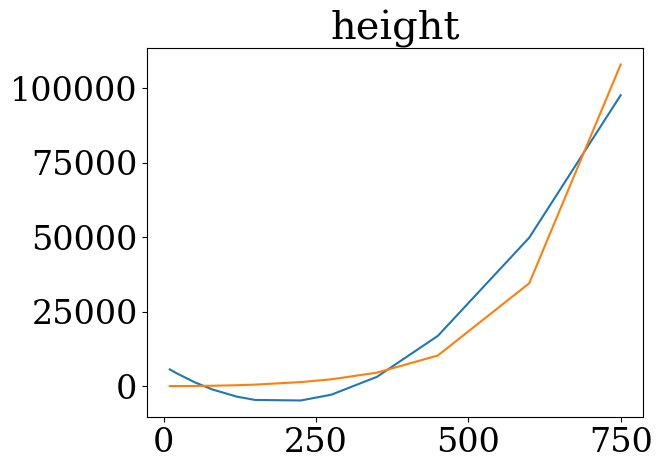

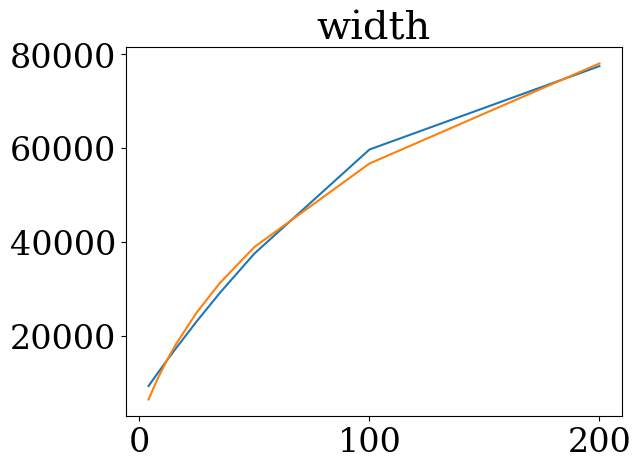

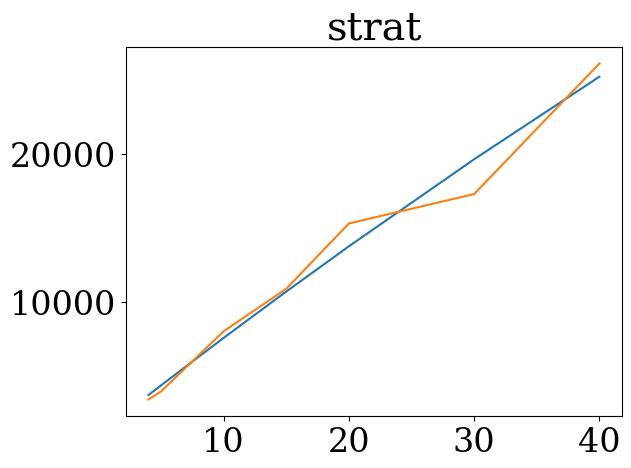

<Figure size 640x480 with 0 Axes>

In [13]:
from sklearn.metrics import r2_score

for name in data:
    
    # Quadratic fit for zonal data
    zonal_fit = np.polyfit(data[name]["zonaldata"]["xax"], (data[name]["zonaldata"]["KEtot"] + data[name]["zonaldata"]["PEtot"] ), 2)
    data[name]["zonaldata"]["quadratic_fit"] = zonal_fit[0] * data[name]["zonaldata"]["xax"]**2 + zonal_fit[1] * data[name]["zonaldata"]["xax"] + zonal_fit[2]
    
    
    # Calculate R-squared error for zonal fit
    zonal_r2 = r2_score(data[name]["zonaldata"]["KEtot"] + data[name]["zonaldata"]["PEtot"], data[name]["zonaldata"]["quadratic_fit"])
    plt.plot(data[name]["zonaldata"]["xax"],data[name]["zonaldata"]["quadratic_fit"])
    plt.plot(data[name]["zonaldata"]["xax"],data[name]["zonaldata"]["KEtot"] + data[name]["zonaldata"]["PEtot"])
    plt.title(name)
    plt.figure()
    # Print the least squares error and R-squared error for each fit
    print(f"R-squared error for {name} zonal fit: {zonal_r2}")


## Linear fit of stratification

R-squared error for strength zonal fit: 0.925994343525741
R-squared error for duration zonal fit: 0.104491176303118
R-squared error for forcing_latwidth zonal fit: 0.07782554683832976
R-squared error for height zonal fit: 0.6682952749595064
R-squared error for width zonal fit: 0.9305543213356373
R-squared error for strat zonal fit: 0.9759262784118735


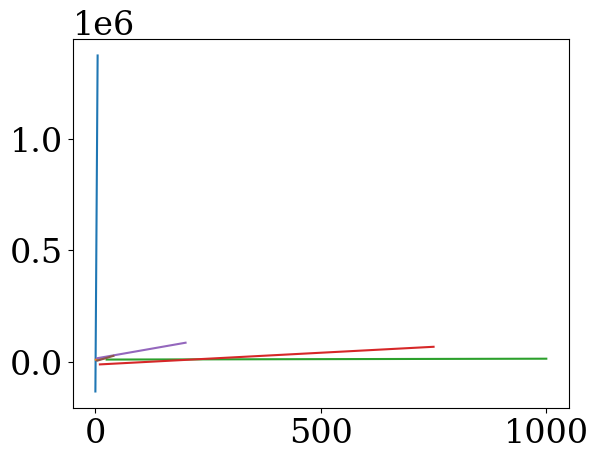

In [14]:
from sklearn.metrics import r2_score

for name in data:
    
    # Quadratic fit for zonal data
    zonal_fit = np.polyfit(data[name]["zonaldata"]["xax"], (data[name]["zonaldata"]["KEtot"] + data[name]["zonaldata"]["PEtot"] ), 1)
    data[name]["zonaldata"]["quadratic_fit"] = zonal_fit[0] * data[name]["zonaldata"]["xax"] + zonal_fit[1] 
    
    
    # Calculate R-squared error for zonal fit
    zonal_r2 = r2_score(data[name]["zonaldata"]["KEtot"] + data[name]["zonaldata"]["PEtot"], data[name]["zonaldata"]["quadratic_fit"])
  
    # Print the least squares error and R-squared error for each fit
    print(f"R-squared error for {name} zonal fit: {zonal_r2}")
    plt.plot(data[name]["zonaldata"]["xax"],data[name]["zonaldata"]["quadratic_fit"])
    


## linear fit of conversion rates 

R-squared error for strength zonal fit: 0.9821746496396073
R-squared error for duration zonal fit: 0.3184827920297544
R-squared error for forcing_latwidth zonal fit: 0.4197243298654677
R-squared error for height zonal fit: 0.06764213059383384
R-squared error for width zonal fit: 0.5092468747713723
R-squared error for strat zonal fit: 0.6886927150951543


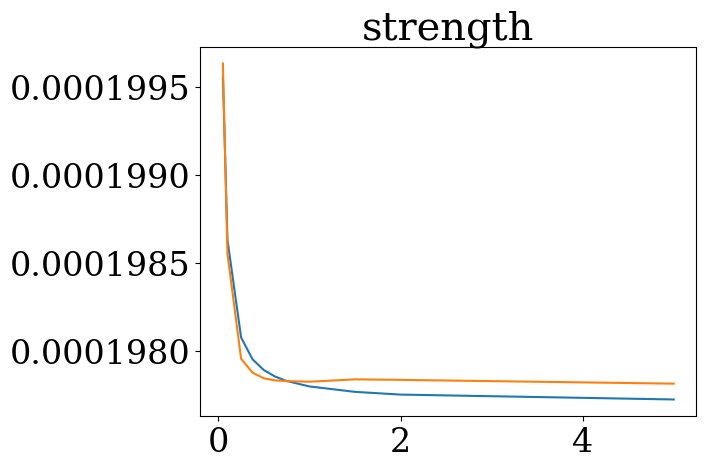

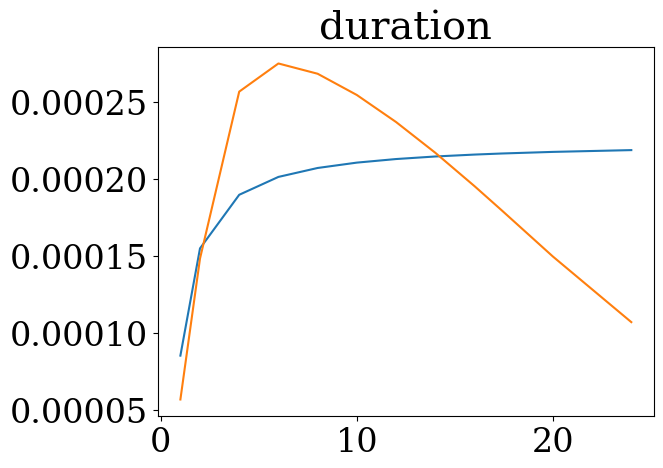

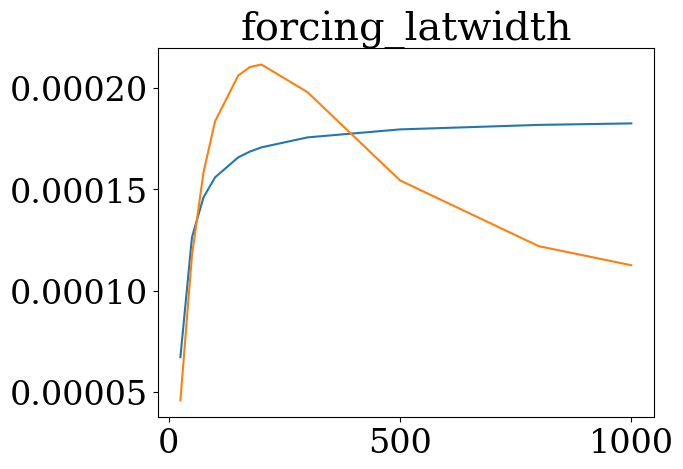

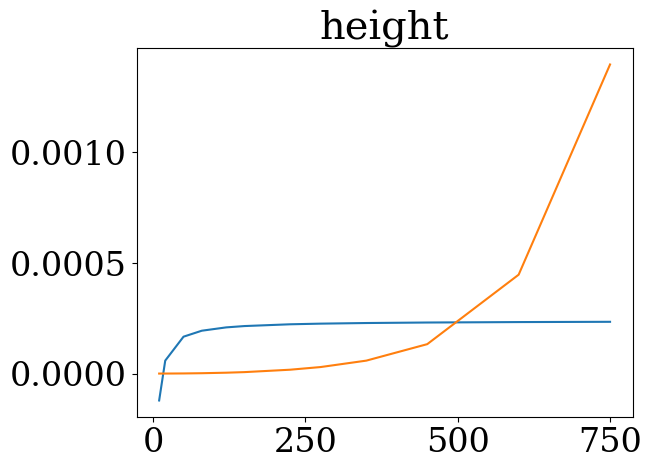

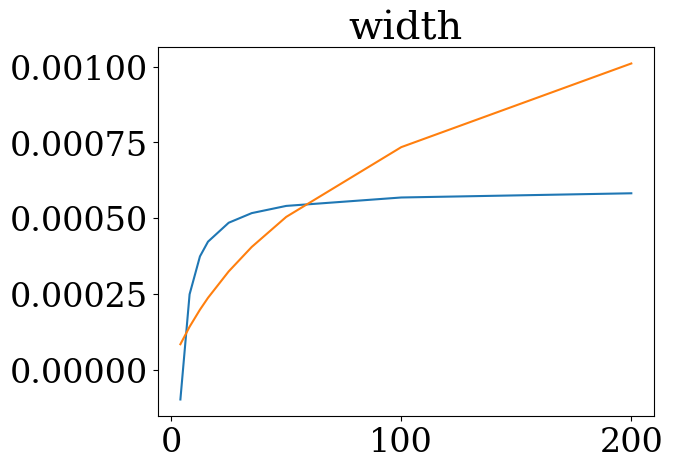

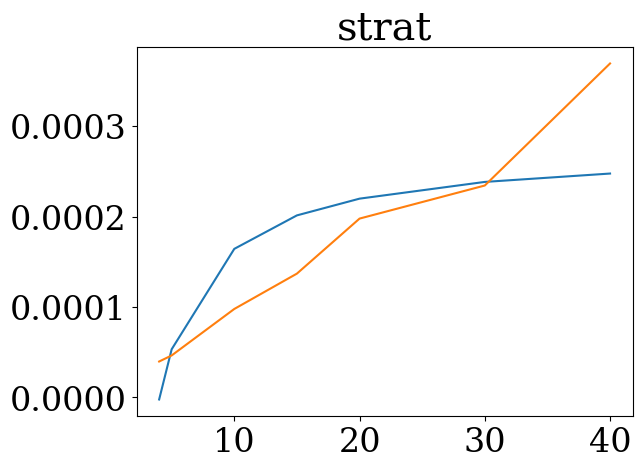

<Figure size 640x480 with 0 Axes>

In [15]:
from sklearn.metrics import r2_score

for name in data:
    
    # Quadratic fit for zonal data
    conversion_rate = (data[name]["zonaldata"]["KEtot"] + data[name]["zonaldata"]["PEtot"] ) / data[name]["zonaldata"]["windw"]

    zonal_fit = np.polyfit(1 / data[name]["zonaldata"]["xax"], conversion_rate, 1)
    data[name]["zonaldata"]["quadratic_fit"] = zonal_fit[0] * 1 / (data[name]["zonaldata"]["xax"]) + zonal_fit[1] 
    
    
    # Calculate R-squared error for zonal fit
    zonal_r2 = r2_score(conversion_rate, data[name]["zonaldata"]["quadratic_fit"])
  
    # Print the least squares error and R-squared error for each fit
    print(f"R-squared error for {name} zonal fit: {zonal_r2}")
    plt.plot(data[name]["zonaldata"]["xax"],data[name]["zonaldata"]["quadratic_fit"])
    plt.plot(data[name]["zonaldata"]["xax"],conversion_rate)
    plt.title(name)
    plt.figure()


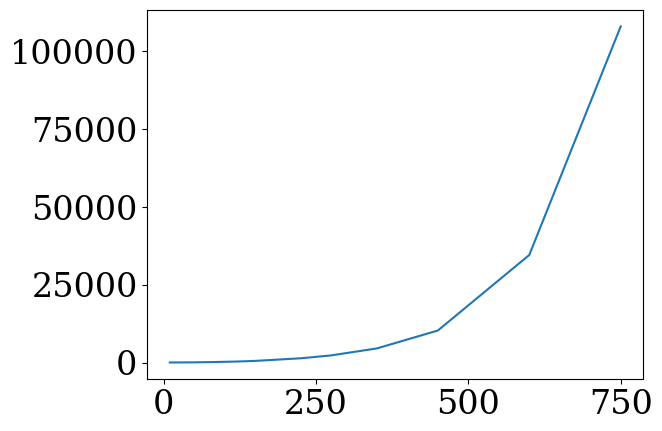

In [36]:
plt.plot(data["height"]["zonaldata"]["xax"],data["height"]["zonaldata"]["PEtot"] + data["height"]["zonaldata"]["KEtot"])


In [23]:
data["strat"]["zonaldata"]["xax"]

array([ 4.,  5., 10., 15., 20., 30., 40.])

In [12]:
stratdata = openexpt("strat",strats,"ridge",layers = 5,merid=False)
strengthdata = openexpt("strength",strengths,"ridge",layers = 5,merid=False)
heightdata = openexpt("height",heights,"ridge",layers = 5,merid=False)
print()
print(100*(stratdata["PEtot"] + stratdata["KEtot"])/stratdata["windw"])
print()
print(100*(strengthdata["PEtot"] + strengthdata["KEtot"])/strengthdata["windw"])
print()
print(100*(heightdata["PEtot"] + heightdata["KEtot"])/heightdata["windw"])

print("MERID")
stratdata = openexpt("strat",strats,"ridge",layers = 5,merid=True)
strengthdata = openexpt("strength",strengths,"ridge",layers = 5,merid=True)
heightdata = openexpt("height",heights,"ridge",layers = 5,merid=True)
print()
print(100*(stratdata["PEtot"] + stratdata["KEtot"])/stratdata["windw"])
print()
print(100*(strengthdata["PEtot"] + strengthdata["KEtot"])/strengthdata["windw"])
print()
print(100*(heightdata["PEtot"] + heightdata["KEtot"])/heightdata["windw"])




[0.00100583 0.00482096 0.00396996 0.00464131 0.00978469 0.01369637
 0.01978458 0.0234439  0.03694707]

[0.01996339 0.01985538 0.01979568 0.01978783 0.01978458 0.01978339
 0.01978301 0.01978266 0.019784   0.0197837  0.01978156]

[9.67406659e-06 1.63951365e-05 6.69705122e-05 1.69080091e-04
 4.01457134e-04 6.63719645e-04 1.75332141e-03 2.95398339e-03
 5.85486984e-03 1.32979096e-02 4.46745289e-02 1.39631378e-01]
MERID

[32.58859429 33.61922009 41.22150017 41.28617483 40.90733997 40.99601418
 42.30069037 43.90187626 54.40082588]

[42.30140945 42.30081507 42.30071937 42.30064616 42.30069037 42.30074743
 42.3006934  42.30059628 42.30065928 42.30030688 42.29237532]

[42.31327795 42.31311258 42.3126921  42.3121743  42.31147192 42.31095884
 42.30894984 42.30756193 42.30549432 42.30226593 42.29797943 42.29407012]
